In [15]:
import os
import numpy as np
import cv2
import json
from scipy.io import loadmat
import h5py
import pandas as pd
from tifffile import imread
import matplotlib.pyplot as plt
import copy

In [16]:
# define paths

pth_WSI_ndpi = r'\\10.162.80.16\Andre_expansion\data\PDAC purity\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2'
pth_segmentation_json = r'\\10.162.80.16\Andre_expansion\data\PDAC purity\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2\StarDist_2_9_24\json'

WSIs = os.listdir(pth_WSI_ndpi)
WSIs = sorted([os.path.join(pth_WSI_ndpi,f) for f in WSIs if f.endswith('.tif')])

jsons = os.listdir(pth_segmentation_json)
jsons = sorted([os.path.join(pth_segmentation_json, f) for f in jsons if f.endswith('.json')])

print(WSIs[0])
print(jsons[0])

print(len(WSIs))
print(len(jsons))

\\10.162.80.16\Andre_expansion\data\PDAC purity\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2\PD_11 2O LCM.tif
\\10.162.80.16\Andre_expansion\data\PDAC purity\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2\StarDist_2_9_24\json\PD_11 2O LCM.json
25
25


In [17]:
jsons

['\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\StarDist_2_9_24\\json\\PD_11 2O LCM.json',
 '\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\StarDist_2_9_24\\json\\PD_12 1F LCM-1-1.json',
 '\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\StarDist_2_9_24\\json\\PD_14 1F LCM.json',
 '\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\StarDist_2_9_24\\json\\PD_15 3Q LCM.json',
 '\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\StarDist_2_9_24\\json\\PD_16 5l LCM-2.json',
 '\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\StarDist_2_9_24\\json\\PD_17 4M LCM.json',
 '\\\\10.162.80.16\\Andre_expansio

In [18]:
WSIs

['\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\PD_11 2O LCM.tif',
 '\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\PD_12 1F LCM-1-1.tif',
 '\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\PD_14 1F LCM.tif',
 '\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\PD_15 3Q LCM.tif',
 '\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\PD_16 5l LCM-2.tif',
 '\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\PD_17 4M LCM.tif',
 '\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\PD_18 2H LCM.tif',
 '\\\\10.162.80.16\\Andre_expansion\\data\

In [19]:
# WSIs = [f for i, f in enumerate(WSIs) if i != 21] # found 21 by running code below, this image wasn't used for some reason in other stuff

In [20]:
# ensure that each file matches up with each other

for i, json_f_name in enumerate(jsons):
    # get name of files without file extensions
    json_name = json_f_name.split('\\')[-1].split('.')[0]
    wsi_name = WSIs[i].split('\\')[-1].split('.')[0]
    #crop_mat_name = crop_mats[i].split('\\')[-1].split('.')[0]
    #pixel_res_name = pixel_res_files[i].split('\\')[-1].split('.')[0]
    
    #print(json_name, wsi_name, crop_mat_name, pixel_res_name)

    if json_name != wsi_name: #or json_name != crop_mat_name or json_name != pixel_res_name:
        print(i)
        print(json_name, wsi_name) #, crop_mat_name, pixel_res_name)
        break

In [21]:
# basic morphology features

def cntarea(cnt):
    cnt = np.array(cnt).astype(np.float32)
    area = cv2.contourArea(cnt)
    return area

def cntperi(cnt):
    cnt = np.array(cnt).astype(np.float32)
    perimeter = cv2.arcLength(cnt,True)
    return perimeter

def cntMA(cnt):
    cnt = np.array(cnt).astype(np.float32)
    #Orientation, Aspect_ratio
    [(x,y),(MA,ma),orientation] = cv2.fitEllipse(cnt)
    return [np.max((MA,ma)),np.min((MA,ma)),orientation]

In [22]:
# functions to adjust format of contours list

def fix_contours(contours):
    contours_fixed = []
    for polygon in contours:
        coords = np.array([list(zip(x,y)) for x,y in [polygon[0]]][0], dtype=np.int32)
        contours_fixed.append(coords)
    contours_fixed = np.array(contours_fixed)
    return contours_fixed


def adjust_contours(contour, crop_x, crop_y):

    for i, xy in enumerate(contour):
        x = xy[0] - crop_x
        y = xy[1] - crop_y
        
        
        contour[i] = [x, y]
    return contour

In [23]:
def get_rbg_avg(centroid, contour_raw, offset, HE_20x_WSI):
    """gets RBG average intensities inside of a contour given the image and centroid
    It is fast because it crops the image so that the image size is offset*2 width/height.
    Python passes HE_20x_WSI as reference so it shouldn't affect performance passing a 
    hugh variable like this."""
    
    x_low = centroid[0] - offset
    x_high = centroid[0] + offset
    y_low = centroid[1] - offset
    y_high = centroid[1] + offset
    
    img_shape = HE_20x_WSI.shape
    
    # if bad shape, return -1 for each intensity mean
    if offset > centroid[0] or offset > centroid[1] or centroid[0] > (img_shape[0] - offset) or centroid[1] > (img_shape[1] - offset):
        print(f'centroid passed: {centroid}')
        r_avg = -1
        g_avg = -1
        b_avg = -1
        return r_avg, g_avg, b_avg
    
    im_crop = np.array(HE_20x_WSI[x_low:x_high, y_low:y_high], dtype=np.uint16)
    
    #plt.imshow(im_crop)
    
    crop_x = centroid[0]-offset-1
    crop_y = centroid[1]-offset-1
    
    contour_adj = adjust_contours(contour_raw, crop_x, crop_y)
    contour_new = contour_adj# .reshape((-1,1,2)).astype(np.uint16)
    rev_contour = contour_new[:, [1, 0]]  # its backwards for some reason idk why but you need to flip it like this
    #rev_contour = contour_new[:,:, [1, 0]]  # its backwards for some reason idk why but you need to flip it like this
    # print(rev_contour)
    
    # coords NEEDS to be np.int32 matrix --> 2 columns x y
    
    # Create a single-channel mask
    mask = np.zeros_like(im_crop[:, :, 0], dtype=np.uint16)  # make black image of same size, will fill with mask

    # Draw contours on the single-channel mask
    #cv2.drawContours(im_crop, [rev_contour], -1, (0,255,0)) #, thickness=cv2.FILLED)  # this one makes it green so that you can see contour
    cv2.drawContours(mask, [rev_contour], 0, (1), thickness=cv2.FILLED)
    
    # plt.imshow(im_crop)
    
    r_pixels = im_crop[:,:,0] * mask  # pixels inside mask are 1, outside == 0
    g_pixels = im_crop[:,:,1] * mask
    b_pixels = im_crop[:,:,2] * mask
    
    num_pixels = np.count_nonzero(mask)
    
    if num_pixels != 0:
        
        r_avg = round(np.sum(r_pixels)/num_pixels,2)
        g_avg = round(np.sum(g_pixels)/num_pixels,2)
        b_avg = round(np.sum(b_pixels)/num_pixels,2)
    
    else:
        print('ZERO PIXEL')
        r_avg = -1
        g_avg = -1
        b_avg = -1
    
    #plt.imshow(im_crop)
    
    return r_avg, g_avg, b_avg

In [24]:
outnm

'\\\\10.162.80.16\\Andre_expansion\\data\\PDAC purity\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\StarDist_2_9_24\\json\\features_pickles\\PD_12 1F LCM-1-.pkl'

In [26]:
outpth = r'\\10.162.80.16\Andre_expansion\data\PDAC purity\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2\StarDist_2_9_24\json\features_pickles'

for i, json_f_name in enumerate(jsons):
    
    nm = json_f_name.split('\\')[-1].split('.')[0]
    
    outnm = os.path.join(outpth, f'{nm}.pkl')
    print(outnm)
    
    if not os.path.exists(outnm):
        
        # delete, just for testing
        #i = 500
        #json_f_name = jsons[500]
        
        HE_20x_WSI = imread(WSIs[i])
        
        print(WSIs[i])
        print(json_f_name)
        
        try:
            segmentation_data = json.load(open(json_f_name))
        except:
            print(f'error reading json... Skipping {json_f_name}')
            continue
    
        centroids = [nuc['centroid'][0] for nuc in segmentation_data]
        contours = [nuc['contour'] for nuc in segmentation_data]
        contours_fixed = fix_contours(contours)
        
        offset = 30  # radius of image that gets cropped from WSI, used for getting rgb intensity average inside nuc contour
        
        centroids_np = np.array(centroids)  # for other formatting
        contours_np = np.array(contours)
        
        r_avg_list = []
        g_avg_list = []
        b_avg_list = []
        
        areas = []
        perimeters = []
        circularities = []
        aspect_ratios = []
        image_ids = []
        classes = []
        
        compactness_a, eccentricity_a, euler_number_a, extent_a, form_factor_a, maximum_radius_a, mean_radius_a, median_radius_a, minor_axis_length_a, orientation_degrees_a = [], [], [], [], [], [], [], [], [], []
        
        
        for j in range(len(contours_fixed)):
            
            centroid = centroids[j]
            # print(f'centroid: {centroid}')
            contour_raw = copy.copy(contours_fixed[j])  # used for rgb intensities
            
            # get rbg intensity averages
            r_avg, g_avg, b_avg = get_rbg_avg(centroid, contour_raw, offset, HE_20x_WSI)
            # print(r_avg, g_avg, b_avg)
            
            r_avg_list.append(r_avg)
            g_avg_list.append(g_avg)
            b_avg_list.append(b_avg)
            
            contour = contours_np[j][0].transpose()  # used for other stuff, too lazy to make formatting the same
            area = cntarea(contour)
            perimeter = cntperi(contour)
            circularity = 4 * np.pi * area / perimeter ** 2
            MA = cntMA(contour)
            [MA, ma, orientation] = MA
            aspect_ratio = MA / ma
            center_x = centroid[0]
            center_y = centroid[1]
            
            compactness = perimeter ** 2 / area
            eccentricity = np.sqrt(1 - (ma / MA) ** 2)
            extent = area / (MA * ma)
            form_factor = (perimeter ** 2) / (4 * np.pi * area)
            major_axis_length = MA
            maximum_radius = np.max(np.linalg.norm(contour - centroid, axis=1))
            mean_radius = np.mean(np.linalg.norm(contour - centroid, axis=1))
            median_radius = np.median(np.linalg.norm(contour - centroid, axis=1))
            minor_axis_length = ma
            orientation_degrees = np.degrees(orientation)
            
            areas.append(area)
            perimeters.append(perimeter)
            circularities.append(circularity)
            aspect_ratios.append(aspect_ratio)
    
            # additional features
            compactness_a.append(compactness)
            eccentricity_a.append(eccentricity)
            extent_a.append(extent)
            form_factor_a.append(form_factor)
            maximum_radius_a.append(maximum_radius)
            mean_radius_a.append(mean_radius)
            median_radius_a.append(median_radius)
            minor_axis_length_a.append(minor_axis_length)
            orientation_degrees_a.append(orientation_degrees)
            
        dat = {
            'Centroid_x': np.array(centroids)[:,1],
            'Centroid_y': np.array(centroids)[:,0],
            'Area': areas,
            'Perimeter': perimeters,
            'Circularity': circularities,
            'Aspect Ratio': aspect_ratios,
            'compactness' : compactness_a,
            'eccentricity' : eccentricity_a,
            'extent' : extent_a,
            'form_factor' : form_factor_a,
            'maximum_radius' : maximum_radius_a,
            'mean_radius' : mean_radius_a,
            'median_radius' : median_radius_a,
            'minor_axis_length' : minor_axis_length_a,
            'orientation_degrees' : orientation_degrees_a,
            'r_mean_intensity' : r_avg_list,
            'g_mean_intensity' : g_avg_list,
            'b_mean_intensity' : b_avg_list
        }
    
        df = pd.DataFrame(dat).astype(np.float16)  # save a little space with float16 type
        
        df.to_pickle(outnm)
        #break
    else:
        print('skipping')


\\10.162.80.16\Andre_expansion\data\PDAC purity\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2\StarDist_2_9_24\json\features_pickles\PD_11 2O LCM.pkl
\\10.162.80.16\Andre_expansion\data\PDAC purity\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2\PD_11 2O LCM.tif
\\10.162.80.16\Andre_expansion\data\PDAC purity\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2\StarDist_2_9_24\json\PD_11 2O LCM.json
\\10.162.80.16\Andre_expansion\data\PDAC purity\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2\StarDist_2_9_24\json\features_pickles\PD_12 1F LCM-1-1.pkl
\\10.162.80.16\Andre_expansion\data\PDAC purity\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2\PD_12 1F LCM-1-1.tif
\\10.162.80.16\Andre_expansion\data\PDAC purity\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2\StarDist_2_9_24\json\PD_12 1F LCM-1-1.json
\\10.162.80.16\Andre_expansion\data\PDAC purity\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2\StarDist_2_9_24\json\features_p

MemoryError: Unable to allocate 14.7 GiB for an array with shape (54912, 96000, 3) and data type bool

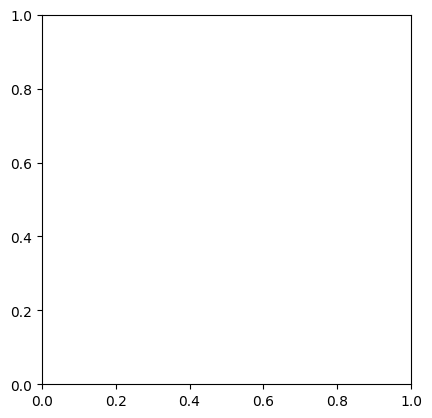

In [213]:
plt.imshow(HE_20x_WSI)

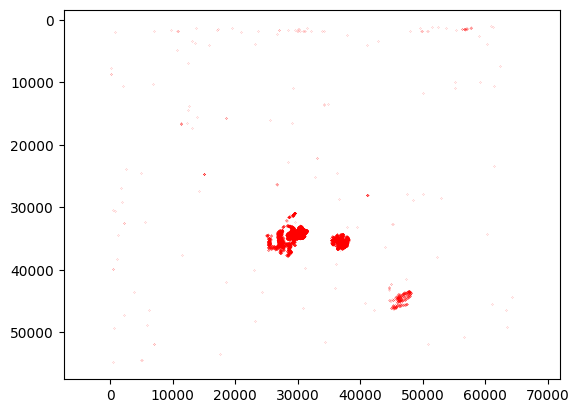

In [264]:
x_temp = df['Centroid_x']
y_temp = df['Centroid_y']

#x_temp = np.array(centroids)[:,0]
#y_temp = np.array(centroids)[:,1]

fig, ax = plt.subplots(1, 1)  # Create a figure and an Axes object

# Plot the image in the first subplot
ax.scatter(x_temp, y_temp, c='red', marker='o', s=.01)
ax.invert_yaxis()

sz = HE_20x_WSI.shape

ax.set_xlim(0, sz[1])  # Replace x_min and x_max with your desired minimum and maximum values for the x-axis
ax.set_ylim(sz[0], 0)  # Replace y_min and y_max with your desired minimum and maximum values for the y-axis

plt.axis('equal')


plt.show()

In [265]:
HE_20x_WSI.shape

(54912, 96000, 3)

In [266]:
df

,Centroid_x,Centroid_y,Area,Perimeter,Circularity,Aspect Ratio,compactness,eccentricity,extent,form_factor,maximum_radius,mean_radius,median_radius,minor_axis_length,orientation_degrees,r_mean_intensity,g_mean_intensity,b_mean_intensity
0,766.0,1932.0,419.500,74.87500,0.940430,1.273438,13.367188,0.619141,0.772461,1.063477,14.164062,11.507812,11.515625,20.656250,2252.0000,114.0625,113.2500,113.4375
1,7008.0,1764.0,225.500,55.84375,0.908203,1.409180,13.835938,0.704590,0.766113,1.100586,12.671875,8.367188,7.984375,14.453125,2037.0000,166.5000,164.1250,162.3750
2,10720.0,1868.0,349.750,82.43750,0.646484,3.404297,19.437500,0.956055,0.756836,1.546875,19.984375,9.718750,7.933594,11.648438,10152.0000,125.3750,122.0000,118.8750
3,10800.0,1868.0,291.000,73.75000,0.671875,3.142578,18.703125,0.948242,0.754883,1.488281,16.359375,8.992188,7.265625,11.078125,74.8125,121.6250,119.1875,116.5000
4,10768.0,1866.0,259.750,69.25000,0.681152,3.037109,18.453125,0.944336,0.755859,1.467773,17.265625,8.476562,7.242188,10.640625,10216.0000,127.8125,122.0625,118.5625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11842,50784.0,51904.0,91.875,36.96875,0.844238,1.641602,14.882812,0.792969,0.760254,1.184570,7.964844,5.316406,5.308594,8.578125,1894.0000,172.7500,164.1250,161.6250
11843,inf,53216.0,232.750,57.21875,0.893555,1.571289,14.062500,0.771484,0.767090,1.119141,12.710938,8.507812,8.109375,13.898438,6272.0000,158.8750,133.3750,144.3750
11844,inf,54112.0,241.250,58.03125,0.900391,1.607422,13.953125,0.783203,0.770508,1.110352,11.703125,8.664062,8.695312,13.953125,179.3750,185.8750,155.2500,173.0000
11845,inf,53504.0,161.375,45.65625,0.972168,1.106445,12.921875,0.427490,0.776855,1.028320,9.031250,7.109375,6.562500,13.703125,63.6875,172.2500,169.6250,169.8750


In [276]:
ind = 1600

row_test = df.iloc[ind]
row_test

Centroid_x             29168.000000
Centroid_y             33984.000000
Area                     193.750000
Perimeter                 50.937500
Circularity                0.938477
Aspect Ratio               1.112305
compactness               13.390625
eccentricity               0.437988
extent                     0.764160
form_factor                1.065430
maximum_radius             9.640625
mean_radius                7.824219
median_radius              7.675781
minor_axis_length         15.093750
orientation_degrees     4224.000000
r_mean_intensity         186.125000
g_mean_intensity         154.125000
b_mean_intensity         189.250000
Name: 1600, dtype: float16

In [277]:
WSIs[i]

'\\\\10.99.68.178\\andreex\\data\\monkey fetus\\gestational 40\\monkey_fetus_40_0001.ndpi'

In [278]:
contour_temp = segmentation_data[ind]['contour'][0]
contour_x = contour_temp[0]
contour_y = contour_temp[1]

print(contour_x, contour_y)

[33984.58630371094, 33983.166748046875, 33981.90270996094, 33980.56311035156, 33979.498291015625, 33978.564453125, 33978.48815917969, 33978.50573730469, 33979.12243652344, 33979.68322753906, 33980.369384765625, 33981.33020019531, 33982.305908203125, 33983.55224609375, 33984.76867675781, 33986.0, 33987.32165527344, 33988.93029785156, 33990.61706542969, 33992.6181640625, 33993.915771484375, 33994.558837890625, 33994.23718261719, 33994.2001953125, 33993.88098144531, 33994.05908203125, 33993.624267578125, 33992.81787109375, 33991.19677734375, 33989.310791015625, 33987.534423828125, 33986.0] [29173.107177734375, 29172.83984375, 29172.1318359375, 29171.436767578125, 29170.34423828125, 29169.079833984375, 29167.494140625, 29166.0, 29164.6318359375, 29163.383544921875, 29162.23779296875, 29161.330078125, 29160.471435546875, 29160.090576171875, 29159.8095703125, 29159.4873046875, 29159.355712890625, 29158.92578125, 29159.090087890625, 29159.3818359375, 29160.710693359375, 29162.454833984375, 29

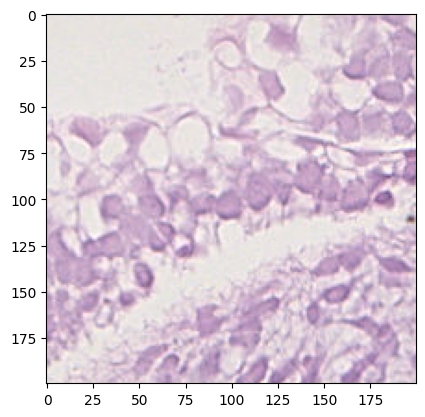

In [282]:
centroid = [int(row_test['Centroid_x']), int(row_test['Centroid_y'])]

offset = 100

x_low = centroid[1] - offset
x_high = centroid[1] + offset
y_low = centroid[0] - offset
y_high = centroid[0] + offset

img_shape = HE_20x_WSI.shape

im_crop = np.array(HE_20x_WSI[x_low:x_high, y_low:y_high], dtype=np.uint16)

plt.imshow(im_crop)



[[106 101]
 [105 100]
 [105  98]
 [104  97]
 [103  96]
 [102  95]
 [100  95]
 [ 99  95]
 [ 97  96]
 [ 96  96]
 [ 95  97]
 [ 94  98]
 [ 93  99]
 [ 93 100]
 [ 92 101]
 [ 92 103]
 [ 92 104]
 [ 91 105]
 [ 92 107]
 [ 92 109]
 [ 93 110]
 [ 95 111]
 [ 97 111]
 [ 99 111]
 [100 110]
 [102 111]
 [104 110]
 [105 109]
 [106 108]
 [106 106]
 [106 104]
 [106 103]]


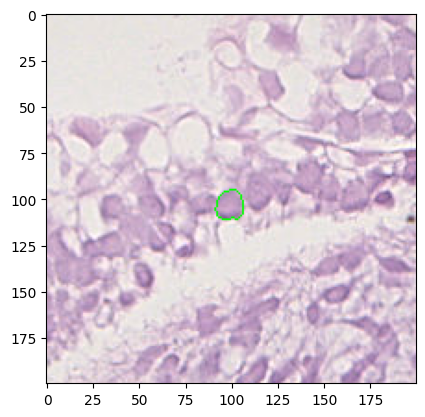

In [283]:
contour_raw = np.array([contour_x,contour_y], dtype=np.uint16).transpose()
contour_raw = np.array([contour_x,contour_y]).transpose()
#print(contour_raw)

contour_adj = adjust_contours(contour_raw, centroid[1]-offset-1, centroid[0]-offset-1)
contour_new = contour_adj.astype(np.int32) #  .reshape((-1,1,2)).astype(np.int16)
#rev_contour = contour_adj[:, [1, 0]]  # its backwards for some reason idk why but you need to flip it like this
rev_contour = contour_new[:, [1, 0]]  # its backwards for some reason idk why but you need to flip it like this
print(rev_contour)

# Create a single-channel mask
mask = np.zeros_like(im_crop[:, :, 0], dtype=np.uint16)  # make black image of same size, will fill with mask

# Draw contours on the single-channel mask
cv2.drawContours(im_crop, [rev_contour], -1, (0,255,0)) #, thickness=cv2.FILLED)  # this one makes it green so that you can see contour
#cv2.drawContours(mask, [rev_contour], 0, (1), thickness=cv2.FILLED)

plt.imshow(im_crop)

In [284]:
row_test

Centroid_x             29168.000000
Centroid_y             33984.000000
Area                     193.750000
Perimeter                 50.937500
Circularity                0.938477
Aspect Ratio               1.112305
compactness               13.390625
eccentricity               0.437988
extent                     0.764160
form_factor                1.065430
maximum_radius             9.640625
mean_radius                7.824219
median_radius              7.675781
minor_axis_length         15.093750
orientation_degrees     4224.000000
r_mean_intensity         186.125000
g_mean_intensity         154.125000
b_mean_intensity         189.250000
Name: 1600, dtype: float16

In [3]:
pth_crop_info_dir = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\2_5x\cropped_images\bounding_boxes'
crop_mat_list = sorted(os.listdir(pth_crop_info_dir))
crop_mat_list = [file for file in crop_mat_list if 'monkey' in file]

In [4]:
crop_mat_list[:5]

['monkey_fetus_40_0001.mat',
 'monkey_fetus_40_0002.mat',
 'monkey_fetus_40_0003.mat',
 'monkey_fetus_40_0004.mat',
 'monkey_fetus_40_0005.mat']

In [6]:
#input folder
jsonsrc = r'\\10.162.80.16\Andre_expansion\data\monkey_fetus\Stardist\StarDist_12_25_23\json'

In [7]:
jsons = sorted(os.listdir(jsonsrc))
jsons = [f for f in jsons if f.endswith('.json')]
print(jsons[0:5])

['monkey_fetus_40_0001.json', 'monkey_fetus_40_0002.json', 'monkey_fetus_40_0003.json', 'monkey_fetus_40_0004.json', 'monkey_fetus_40_0005.json']


In [8]:
# sometimes loading .mat file works with loadmat function from scipi.io, sometimes it doesn't and needs h5py module, so both cases are accounted for here

crop_data = []

for i, file in enumerate(crop_mat_list):
    mat_file_name = os.path.join(pth_crop_info_dir, file)
    try:
        data = loadmat(mat_file_name)

        #print('scipy.io loadmat')
        bb = [int(x) for x in data['bb']]
        crop_data.append(bb)
        #print(bb)

    except:
        data = h5py.File(mat_file_name, 'r')

        #print('h5py')
        bb = [int(x) for x in data['bb'][()]]
        crop_data.append(bb)
        #print(bb)

In [9]:
# pixel res:
pth_pixel_res = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\segmentation_analysis\pix_res_info'
pixel_res_info = sorted(os.listdir(pth_pixel_res))
pixel_res_files = [file for file in pixel_res_info if file.endswith('.mat')]

In [10]:
pixel_res_info = []

for i, file in enumerate(pixel_res_files):
    mat_file_name = os.path.join(pth_pixel_res, file)
    try:
        data = loadmat(mat_file_name)

        #print('scipy.io loadmat')
        x = float(data['pix_res']['x'][0][0][0])
        y = float(data['pix_res']['x'][0][0][0])
        pixel_res_info.append([x, y])

    except:
        data = h5py.File(mat_file_name, 'r')

        #print('h5py')
        x = float(data['pix_res'][()]['x'][0][0][0])
        y = float(data['pix_res'][()]['x'][0][0][0])
        pixel_res_info.append([x, y])

In [12]:
print(f'length crop data: {len(crop_data)}')
print(f'length jsons: {len(jsons)}')
print(f'length res info: {len(pixel_res_info)}')

length crop data: 1154
length jsons: 1154
length res info: 1154


In [13]:
print(crop_data[0])
print(jsons[0])
print(pixel_res_info[0])

[2279, 5816, 2910, 5498]
monkey_fetus_40_0001.json
[0.44157908681444846, 0.44157908681444846]


In [57]:
outpth_pickle = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\segmentation_analysis\model1_class_info_pickles_12_4'

In [14]:
for i, file in enumerate(jsons):
    i = 864
    file = jsons[i]
    fname = os.path.join(jsonsrc, file)
    print(fname)

    outpth = os.path.join(outpth_pickle, ''.join([file[:-5], '.pickle'])) # without .json
    # print(outpth)
    if not os.path.exists(outpth):

        imID = int(fname[-9:-5])

        with open(fname, 'r') as file_n:
            data = json.load(file_n)

        crop_file_data = [num*downsize2_5x for num in crop_data[i]]  # multiple bounding box data by 2_5x crop ratio to get offsets for 20x points
        #print(crop_file_data)

        pix_res = pixel_res_info[i][0]  # this is assuming x and y pix size are equal

        downsize10x = 1/pix_res
        downsize5x = 2/pix_res
        downsize2_5x = 4/pix_res

        #print(crop_file_data)

        # sometimes Andre drew cropping box from bottom to top, and this messed up my code, so I made this to fix it
        #if crop_file_data[3] < crop_file_data[2]:
        #    temp = crop_file_data[2]
        #    crop_file_data[2] = crop_file_data[3]
        #    crop_file_data[3] = temp

        #if crop_file_data[1] < crop_file_data[0]:
        #    temp = crop_file_data[0]
        #    crop_file_data[0] = crop_file_data[1]
        #    crop_file_data[1] = temp

        #print(crop_file_data)




        x_offset = crop_file_data[0] - 1  # 0 to 1 indexing fix, probably right idk
        y_offset = crop_file_data[2] - 1

        centroids = []
        contours = []

        for entry in data:
            cent = entry['centroid'][0]
            cent = [cent[0] - x_offset, cent[1] - y_offset]  # coord might be backwards, idk
            cent = [num/downsize5x for num in cent]

            x_end = (crop_file_data[1] - x_offset)/downsize5x
            y_end = (crop_file_data[3] - y_offset)/downsize5x

            if (0 <= cent[0] < y_end) and (0 <= cent[1] < x_end):
                centroids.append(cent)
                c = entry['contour'][0]
                contour = []
                for j in range(len(c[0])):
                    point = [c[0][j] - x_offset, c[1][j] - y_offset]
                    point = [num/downsize5x for num in point]
                    contour.append(point)
                contours.append(contour)

        centroids = np.array(centroids)
        contours = np.array(contours)

        if len(centroids) == 0:
            print(f'Skipping {file}')
        else:

            areas = []
            perimeters = []
            circularities = []
            aspect_ratios = []
            image_ids = []
            classes = []

            compactness_a, eccentricity_a, euler_number_a, extent_a, form_factor_a, maximum_radius_a, mean_radius_a, median_radius_a, minor_axis_length_a, orientation_degrees_a = [], [], [], [], [], [], [], [], [], []

            for j, centroid in enumerate(centroids):
                contour = contours[j]
                area = cntarea(contour)
                perimeter = cntperi(contour)
                circularity = 4 * np.pi * area / perimeter ** 2
                MA = cntMA(contour)
                [MA, ma, orientation] = MA
                aspect_ratio = MA / ma
                imID = imID
                clas = m1_im[round(centroid[0]), round(centroid[1])]
                center_x = centroid[0]
                center_y = centroid[1]

                # Additional features
                compactness = perimeter ** 2 / area
                eccentricity = np.sqrt(1 - (ma / MA) ** 2)
                extent = area / (MA * ma)
                form_factor = (perimeter ** 2) / (4 * np.pi * area)
                major_axis_length = MA
                maximum_radius = np.max(np.linalg.norm(contour - centroid, axis=1))
                mean_radius = np.mean(np.linalg.norm(contour - centroid, axis=1))
                median_radius = np.median(np.linalg.norm(contour - centroid, axis=1))
                minor_axis_length = ma
                orientation_degrees = np.degrees(orientation)

                areas.append(area)
                perimeters.append(perimeter)
                circularities.append(circularity)
                aspect_ratios.append(aspect_ratio)
                image_ids.append(imID)
                classes.append(clas)

                # additional features
                compactness_a.append(compactness)
                eccentricity_a.append(eccentricity)
                extent_a.append(extent)
                form_factor_a.append(form_factor)
                maximum_radius_a.append(maximum_radius)
                mean_radius_a.append(mean_radius)
                median_radius_a.append(median_radius)
                minor_axis_length_a.append(minor_axis_length)
                orientation_degrees_a.append(orientation_degrees)

            dat = {
                'Centroid_x': centroids[:,0],
                'Centroid_y': centroids[:,1],
                'Class': classes,
                'Area': areas,
                'Perimeter': perimeters,
                'Circularity': circularities,
                'Aspect Ratio': aspect_ratios,

                'compactness' : compactness_a,
                'eccentricity' : eccentricity_a,
                'extent' : extent_a,
                'form_factor' : form_factor_a,
                'maximum_radius' : maximum_radius_a,
                'mean_radius' : mean_radius_a,
                'median_radius' : median_radius_a,
                'minor_axis_length' : minor_axis_length_a,
                'orientation_degrees' : orientation_degrees_a,

                'Image ID': image_ids
            }

            df = pd.DataFrame(dat)

            df.head()
            break
            df.to_pickle(outpth)
    break


\\10.162.80.16\Andre_expansion\data\monkey_fetus\Stardist\StarDist_12_25_23\json\monkey_fetus_40_0895.json


NameError: name 'outpth_pickle' is not defined

In [81]:
centroids = []
contours = []

for entry in data:
    cent = entry['centroid'][0]
    cent = [cent[0] - x_offset, cent[1] - y_offset]  # coord might be backwards, idk
    cent = [num/downsize5x for num in cent]
    print(cent)
    print

    x_end = (crop_file_data[1] - x_offset)/downsize5x
    y_end = (crop_file_data[3] - y_offset)/downsize5x

    if (0 <= cent[0] < y_end) and (0 <= cent[1] < x_end):
        centroids.append(cent)
        c = entry['contour'][0]
        contour = []
        for j in range(len(c[0])):
            point = [c[0][j] - x_offset, c[1][j] - y_offset]
            point = [num/downsize5x for num in point]
            contour.append(point)
        contours.append(contour)

centroids = np.array(centroids)
contours = np.array(contours)

print(centroids)

[-6270.693279166298, -5065.020577585446]
[-6300.2790779828665, -5388.256469133621]
[-6300.720657069681, -5724.739733286231]
[-6299.837498896052, -5306.564338072949]
[-5935.9763313609465, -5333.5006623686295]
[-6299.837498896052, -5283.1606464717825]
[-6300.2790779828665, -5506.158085313079]
[-6300.720657069681, -5525.145986046101]
[-6299.837498896052, -5403.711737172127]
[-5968.653183785216, -5283.1606464717825]
[-6306.019606111455, -4928.131060672967]
[-6303.8117106773825, -5124.192175218582]
[-6302.486973416939, -5147.595866819747]
[-6304.253289764197, -5059.721628543672]
[-5890.052106332244, -5168.350083900026]
[-6306.019606111455, -4936.079484235626]
[-6299.837498896052, -5311.863287114722]
[-6300.720657069681, -5444.337013159056]
[-6306.461185198269, -5015.122140775413]
[-6295.421708027908, -5516.314404309812]
[-6301.162236156496, -5462.883334805263]
[-6294.096970767464, -4343.480349730637]
[-6298.5127616356085, -4670.690453060143]
[-6309.110659719156, -4558.087785922458]
[-6310.4

In [87]:
print(x_end)
print(y_end)

256.22078954340736
2624.220789543407


In [50]:
df.head()

,Centroid_x,Centroid_y,Class,Area,Perimeter,Circularity,Aspect Ratio,Image ID
0,195.819659,917.834496,14,3.802460,7.232203,0.913552,1.246588,1
1,288.109688,2089.785393,14,2.069219,5.637719,0.818106,1.571923,1
2,658.594542,691.304425,14,1.700457,5.131146,0.811609,1.139400,1
3,353.904972,360.561689,14,1.154875,4.315290,0.779336,1.233959,1
4,467.832377,446.669611,14,1.310987,4.574769,0.787172,1.198028,1


In [52]:
np.unique(df['Class'])

array([12, 14], dtype=uint8)

In [90]:
import CellProfiler as cp

ModuleNotFoundError: No module named 'CellProfiler'